In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, activations

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [2]:
data = pd.read_csv('datasets/insurance_processed.csv')

data.sample(10)

,age,bmi,children,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest,charges
756,-0.014740,-1.289947,1.580926,0,0,1,0,0,0,7985.81500
163,-0.513149,-0.141635,0.751079,0,0,0,0,0,1,5152.13400
1010,0.626070,-1.289947,-0.908614,0,0,0,0,0,1,8269.04400
1144,0.768473,0.268476,0.751079,1,0,0,0,0,1,9630.39700
1314,-0.655551,-1.149689,1.580926,0,1,0,1,0,0,18765.87545
50,-1.509965,0.813924,-0.908614,0,0,1,0,0,0,2211.13075
1275,1.266881,-1.142307,-0.908614,1,0,0,0,0,1,10959.33000
26,1.694088,-1.243194,-0.908614,0,0,1,0,0,0,14451.83515
1216,0.056461,-0.915925,-0.908614,1,0,0,0,1,0,5415.66120
1327,0.839674,-0.103905,-0.078767,1,0,0,0,1,0,9377.90470


In [3]:
data.shape

(1338, 10)

In [4]:
features = data.drop('charges', axis=1)
target = data[['charges']]

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2,
                                                    random_state=1)

In [6]:
x_train.shape, x_test.shape

((1070, 9), (268, 9))

In [7]:
y_train.shape, y_test.shape

((1070, 1), (268, 1))

### Writing Custom layer (Dense layer)

In [8]:
class MyDense(layers.Layer):
    
    def __init__(self, units, activation=None, **kwargs):
        
        super(MyDense, self).__init__(**kwargs)
        
        self.units = units
        self.activation = activations.get(activation)
        
    def build(self, input_shape):
        input_dim = input_shape[-1]
        
        self.kernel = self.add_weight(shape=(input_dim, self.units))
        
    def call(self, inputs):
        output = tf.matmul(inputs, self.kernel)
        
        if self.activation is not None:
            output = self.activation(output)
        
        return output
    
    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        
        return tuple(output_shape)
    
    def get_config(self):
        config = super(MyDense, self).get_config()
        
        current_config = {
            'units': self.units,
            'activation': activations.serialize(self.activation)
        }
        
        config.update(current_config)

        return config

### Building model using custom layers

In [9]:
def build_model():
    
    model = tf.keras.Sequential([
        MyDense(64, activation='elu', input_shape=[x_train.shape[1]]),
        MyDense(32, activation='elu'),
        
        layers.Dropout(0.2),
        
        MyDense(16, activation='elu'),
        MyDense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [10]:
sequential_model = build_model()

sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_dense (MyDense)           (None, 64)                576       
_________________________________________________________________
my_dense_1 (MyDense)         (None, 32)                2048      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
my_dense_2 (MyDense)         (None, 16)                512       
_________________________________________________________________
my_dense_3 (MyDense)         (None, 1)                 16        
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________


In [11]:
sequential_model.layers

### Training model

In [12]:
n_epochs = 1000

training_hist= sequential_model.fit(x_train, 
                                    y_train,
                                    epochs=n_epochs, 
                                    validation_split = 0.2, 
                                    verbose=False,
                                    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:317024805.0841,  mae:13316.7305,  mse:317024864.0000,  val_loss:336038027.9626,  val_mae:12875.0137,  val_mse:336038016.0000,  
....................................................................................................
Epoch: 100, loss:34995598.4299,  mae:4027.5391,  mse:34995596.0000,  val_loss:27356289.1215,  val_mae:3352.4150,  val_mse:27356290.0000,  
....................................................................................................
Epoch: 200, loss:28853252.9346,  mae:3384.4492,  mse:28853258.0000,  val_loss:22693998.4299,  val_mae:2714.2214,  val_mse:22693998.0000,  
....................................................................................................
Epoch: 300, loss:28396503.8879,  mae:3398.8367,  mse:28396506.0000,  val_loss:21545181.1589,  val_mae:2547.9399,  val_mse:21545180.0000,  
....................................................................................................
Epoch: 400, loss:28354744.6075,  ma

### Predicting and plotting 

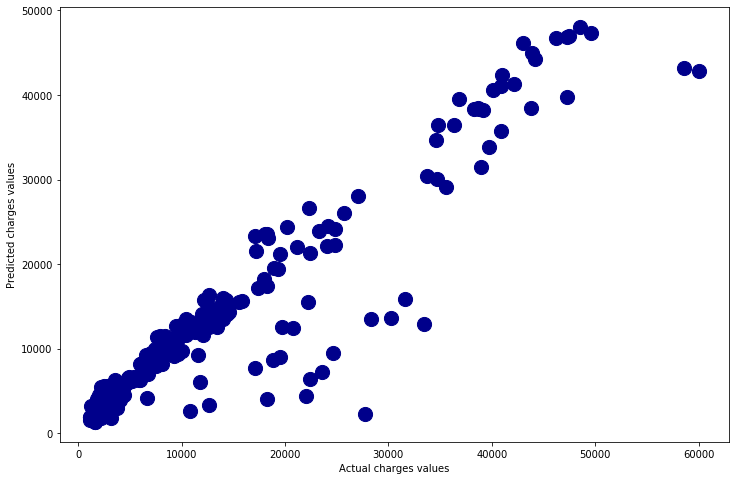

In [13]:
y_pred = sequential_model.predict(x_test).flatten()

plt.figure(figsize=(12, 8))

plt.scatter(y_test, y_pred, s=200, c='darkblue')

plt.xlabel('Actual charges values')
plt.ylabel('Predicted charges values')
plt.show()

In [14]:
r2_score(y_test, y_pred)

0.8692979215857355

### Custom model

In [15]:
class CustomRegressionModel(tf.keras.Model):
    
    def __init__(self, input_shape, layer_units=[8, 4], \
                 activation='relu'):
        
        super(CustomRegressionModel, self).__init__()
        
        assert len(layer_units) > 0

        self.input_layer = MyDense(layer_units[0],
                                   activation=activation,
                                   input_shape=[input_shape])
        
        self.hidden_layers = []
        
        for i in range(1, len(layer_units)):
            self.hidden_layers.append(MyDense(layer_units[i],
                                              activation=activation))

        self.output_layer = MyDense(1)
        
    def call(self, input_tensor):
        
        x = self.input_layer(input_tensor)
                               
        for layer in self.hidden_layers:
            x = layer(x)

        result = self.output_layer(x)
        
        return result

In [16]:
custom_model = CustomRegressionModel(x_train.shape[1], [64, 32, 16], 'elu')

custom_model(tf.zeros([5, x_train.shape[1]]))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [17]:
custom_model.layers

In [18]:
custom_model.summary()

Model: "custom_regression_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_dense_4 (MyDense)         multiple                  576       
_________________________________________________________________
my_dense_5 (MyDense)         multiple                  2048      
_________________________________________________________________
my_dense_6 (MyDense)         multiple                  512       
_________________________________________________________________
my_dense_7 (MyDense)         multiple                  16        
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________


In [19]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

custom_model.compile(loss='mse',
                     optimizer=tf.keras.optimizers.RMSprop(0.001),
                     metrics=['mse'])

In [20]:
n_epochs = 1000

training_hist = custom_model.fit(x_train.values, 
                                 y_train.values,
                                 epochs=n_epochs, 
                                 validation_split = 0.2, 
                                 verbose=False,
                                 callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:317019615.5514,  mse:317019616.0000,  val_loss:336013048.8224,  val_mse:336013056.0000,  
....................................................................................................
Epoch: 100, loss:26028472.3551,  mse:26028478.0000,  val_loss:23986124.0000,  val_mse:23986124.0000,  
....................................................................................................
Epoch: 200, loss:22987883.4393,  mse:22987886.0000,  val_loss:21818801.9439,  val_mse:21818804.0000,  
....................................................................................................
Epoch: 300, loss:21981358.9346,  mse:21981358.0000,  val_loss:21531283.1776,  val_mse:21531284.0000,  
....................................................................................................
Epoch: 400, loss:21394439.6262,  mse:21394442.0000,  val_loss:21444915.5140,  val_mse:21444914.0000,  
..............................................................................

### Plotting epoch vs loss graph

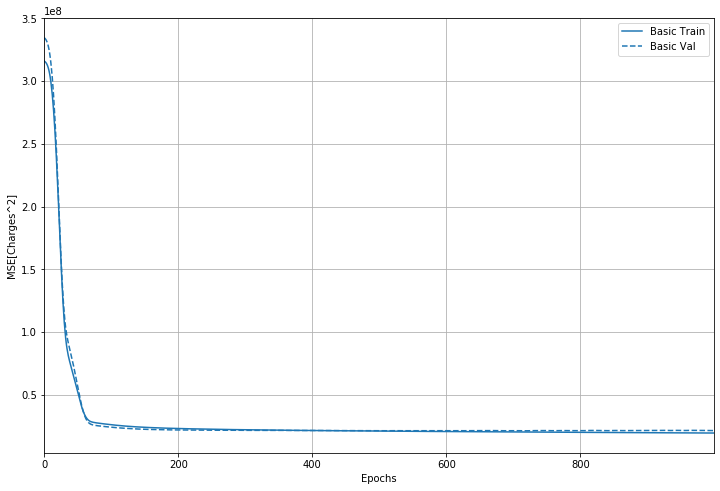

In [21]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plt.figure(figsize=(12, 8))

plotter.plot({'Basic': training_hist}, metric = "mse")

plt.ylabel('MSE[Charges^2]')
plt.show()

### Predictng and plotting actual and predicted values

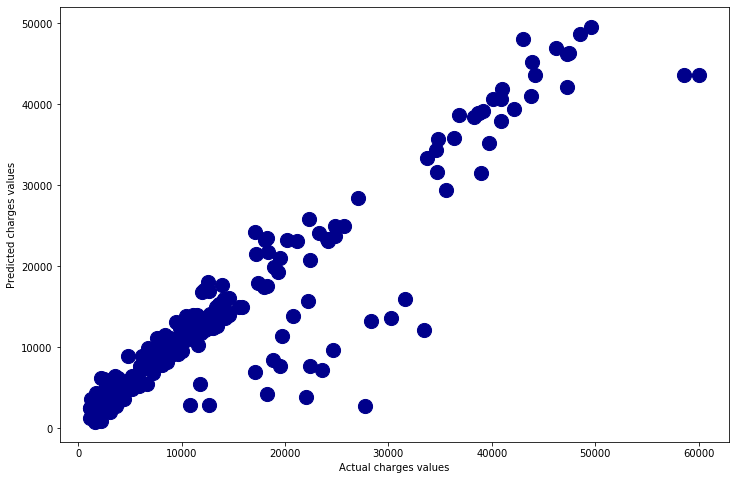

In [22]:
y_pred = custom_model.predict(x_test.values).flatten()

plt.figure(figsize=(12, 8))

plt.scatter(y_test, y_pred, s=200, c='darkblue')

plt.xlabel('Actual charges values')
plt.ylabel('Predicted charges values')
plt.show()

In [23]:
r2_score(y_test, y_pred)

0.8697965969517945

In [24]:
custom_model.save_weights('my_models/custom_model.h5', save_format="h5")

### Creating weights and loading weights

In [25]:
new_model = CustomRegressionModel(x_train.shape[1], [64, 32, 16], 'elu')

new_model(tf.zeros([5, x_train.shape[1]]))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [26]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

new_model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.RMSprop(0.001),
                  metrics=['mse'])

In [27]:
new_model.load_weights('my_models/custom_model.h5')

### Evaluating model

In [28]:
y_pred_new = new_model.predict(x_test.values)

r2_score(y_test, y_pred_new)

0.8697965969517945